In [ ]:
! pip install transformers
! pip install datasets

In [6]:
from datasets import load_dataset

dataset = load_dataset("maartengr/arxiv_nlp")["train"]

abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [40]:
print(dataset)
print(np.unique(dataset["Years"]))
print(np.unique(dataset["Categories"]))

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})
[1991 1992 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023 2024]
['Computation and Language']


In [10]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("thenlper/gte-small", device="cuda")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [6]:
embeddings.shape

(44949, 384)

## Reducing the Dimensionality



In [7]:
from umap import UMAP

umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
reduced_embeddings.shape

(44949, 5)

## Cluster the Reduced Embeddings

In [ ]:
! pip install hdbscan

In [15]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=50, metric="euclidean", cluster_selection_method="eom").fit(reduced_embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
clusters = hdbscan_model.labels_
len(set(clusters))

156

In [19]:
clusters

array([ -1,  -1,  -1, ...,  -1, 130,  -1])

## Inspecting the Clusters

In [22]:
import numpy as np

cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [45]:
np.where(clusters==cluster)[0][:3]

array([425, 456, 457])

In [48]:
counter = 0
cluster = 0
for i, cl in enumerate(clusters):
  if cl == cluster:
    print(dataset["Years"][i])
    print(titles[i])
    print(abstracts[i][:300] + "... \n")
    counter += 1
  if counter == 3:
    break

2011
Statistical Sign Language Machine Translation: from English written text
  to American Sign Language Gloss
  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

2012
Toward a Motor Theory of Sign Language Perception
  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

2012
Toward an example-based machine translation from written text to ASL
  using virtual agent animation
  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using som

In [23]:
import pandas as pd

reduced_embeddings = UMAP(n_components=2, min_dist=0.0, metric="cosine", random_state=42).fit_transform(embeddings)

In [56]:
# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

In [51]:
df

x          y                                              title  \
0      5.095184   9.907012  Introduction to Arabic Speech Recognition Usin...   
1      5.090229   9.918795  Arabic Speech Recognition System using CMU-Sph...   
2      4.641611  10.343224  On the Development of Text Input Method - Less...   
3      0.012539  10.586321  Network statistics on early English Syntax: St...   
4      4.281412   8.118710  Segmentation and Context of Literary and Music...   
...         ...        ...                                                ...   
44944  2.334228  12.144953  Resolution of Verb Ellipsis in Japanese Senten...   
44945  3.552228  11.661524  An Example-Based Approach to Japanese-to-Engli...   
44946 -0.831134  11.170600  Deduction over Mixed-Level Logic Representatio...   
44947  1.408210  12.338858   HMM Specialization with Selective Lexicalization   
44948 -0.809195  11.169418  Mixed-Level Knowledge Representation and Varia...   

      cluster  
0          -1  
1          -1  
2          -1  
3          -1  
4          17  
...       ...  
44944      -1  
44945      -1  
44946      -1  
44947     130  
44948      -1  

[44949 rows x 4 columns]

(np.float64(-8.865413880348205),
 np.float64(11.152206158638),
 np.float64(-1.254298309981823),
 np.float64(17.36097658723593))

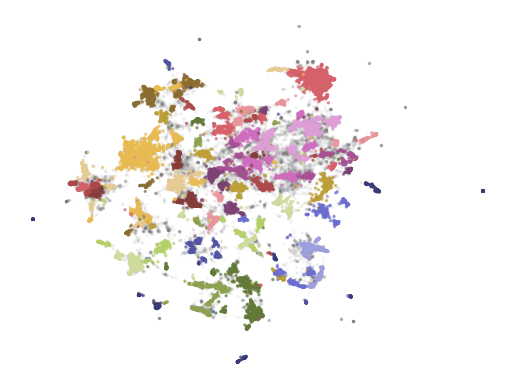

In [58]:
import matplotlib.pyplot as plt

plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int), alpha=0.6, s=2, cmap="tab20b")
plt.axis("off")

## From Text Clustering to Topic Modeling

In [ ]:
! pip install bertopic

In [11]:
from bertopic import BERTopic
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from umap import UMAP

embedding_model = SentenceTransformer("thenlper/gte-small", device="cuda")
umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=50, metric="euclidean", cluster_selection_method="eom")

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-03-23 02:41:19,243 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-23 02:42:31,944 - BERTopic - Dimensionality - Completed ✓
2025-03-23 02:42:31,946 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-23 02:42:37,673 - BERTopic - Cluster - Completed ✓
2025-03-23 02:42:37,696 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-23 02:42:41,619 - BERTopic - Representation - Completed ✓


In [12]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14989                               -1_the_of_and_to   
1        0   2165                 0_question_questions_answer_qa   
2        1   2099                   1_speech_asr_recognition_end   
3        2    905  2_summarization_summaries_summary_abstractive   
4        3    834              3_hate_offensive_speech_detection   
..     ...    ...                                            ...   
151    150     53            150_gans_gan_adversarial_generation   
152    151     52                151_recipes_recipe_cooking_food   
153    152     51                152_moe_experts_mixture_routing   
154    153     50    153_opinion_reviews_summaries_summarization   
155    154     50          154_sentence_embeddings_sts_embedding   

                                        Representation  \
0    [the, of, and, to, in, we, for, language, that...   
1    [question, questions, answer, qa, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [summarization, summaries, summary, abstractiv...   
4    [hate, offensive, speech, detection, toxic, so...   
..                                                 ...   
151  [gans, gan, adversarial, generation, generativ...   
152  [recipes, recipe, cooking, food, ingredients, ...   
153  [moe, experts, mixture, routing, expert, spars...   
154  [opinion, reviews, summaries, summarization, r...   
155  [sentence, embeddings, sts, embedding, similar...   

                                   Representative_Docs  
0    [  This paper describes our system developed f...  
1    [  The ability to ask questions is important i...  
2    [  Training state-of-the-art Automated Speech ...  
3    [  Document summarization provides an instrume...  
4    [  Current research on hate speech analysis is...  
..                                                 ...  
151  [  Text generation is of particular interest i...  
152  [  Decoding the core of procedural texts, exem...  
153  [  The Mixture of Experts (MoE) models are an ...  
154  [  When faced with a large number of product r...  
155  [  Sentence representation at the semantic lev...  

[156 rows x 5 columns]

In [17]:
topic_model.get_topic(0)

[('question', np.float64(0.021698155155324556)),
 ('questions', np.float64(0.016275385459456792)),
 ('answer', np.float64(0.016203757544143365)),
 ('qa', np.float64(0.016112964340031743)),
 ('answering', np.float64(0.015158035927654866)),
 ('answers', np.float64(0.010140150829836101)),
 ('retrieval', np.float64(0.009440680592927787)),
 ('comprehension', np.float64(0.007912631094997931)),
 ('reading', np.float64(0.007371337360337285)),
 ('hop', np.float64(0.006341766644496478))]

In [18]:
topic_model.find_topics("topic modeling")

([25, -1, 38, 37, 87],
 [np.float32(0.95468587),
  np.float32(0.91189206),
  np.float32(0.90798604),
  np.float32(0.9053211),
  np.float32(0.9043177)])

In [19]:
topic_model.get_topic(25)

[('topic', np.float64(0.0682295755117711)),
 ('topics', np.float64(0.03584769939100283)),
 ('lda', np.float64(0.016612829612453788)),
 ('latent', np.float64(0.013993692937424855)),
 ('documents', np.float64(0.012790711735850007)),
 ('document', np.float64(0.012636418670234338)),
 ('modeling', np.float64(0.011805587287798286)),
 ('dirichlet', np.float64(0.010302740450987427)),
 ('word', np.float64(0.008804657665505042)),
 ('allocation', np.float64(0.008107527073191055))]

In [20]:
topic_model.get_topic(38)

[('scientific', np.float64(0.028738969159960232)),
 ('citation', np.float64(0.028561462662928572)),
 ('papers', np.float64(0.02778098057586106)),
 ('citations', np.float64(0.013279571412585584)),
 ('review', np.float64(0.01058169068958178)),
 ('peer', np.float64(0.010564784470292415)),
 ('scholarly', np.float64(0.010531616488395281)),
 ('research', np.float64(0.010360338094468844)),
 ('academic', np.float64(0.01003046336558536)),
 ('paper', np.float64(0.008037906289590991))]

In [21]:
topic_model.topics_[titles.index("BERTopic: Neural topic modeling with a class-based TF-IDF procedure")]

25

In [24]:
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

fig.update_layout(font=dict(size=16))

In [25]:
topic_model.visualize_barchart()

In [26]:
topic_model.visualize_heatmap(n_clusters=30)

In [27]:
topic_model.visualize_hierarchy()

## Adding a Special Lego Block

In [28]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [29]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

## KeyBERTInspired

In [30]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | answer | qa | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  summarization | summaries | summary | abstract...   
3      3      hate | offensive | speech | detection | toxic   
4      4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  answering | questions | comprehension | questi...  
1  phonetic | language | speech | encoder | trans...  
2  summarization | summarizers | summaries | summ...  
3  hate | hateful | language | offensive | languages  
4       gender | gendered | bias | biases | pronouns

## Maximal marginal relevance

In [31]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | answer | qa | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  summarization | summaries | summary | abstract...   
3      3      hate | offensive | speech | detection | toxic   
4      4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  questions | retrieval | comprehension | hop | ...  
1           speech | asr | error | automatic | model  
2  summarization | extractive | documents | evalu...  
3        hate | toxic | social | platforms | dataset  
4  gender | bias | fairness | stereotypes | language

## The Text Generation Lego Block

In [32]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 156/156 [00:14<00:00, 10.98it/s]


Topic                                           Original  \
0      0     question | questions | answer | qa | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  summarization | summaries | summary | abstract...   
3      3      hate | offensive | speech | detection | toxic   
4      4      gender | bias | biases | debiasing | fairness   

                                          Updated  
0                  Question answering |  |  |  |   
1  Speech-to-speech comparison metric |  |  |  |   
2                       Summarization |  |  |  |   
3                hate speech analysis |  |  |  |   
4                        Science/Tech |  |  |  |